# Smart Optimization to Save Computing Time

In [ ]:
???

<table style="width:100%; height:90%">
      <tr>
    <th>Grid Search</th>
    <th>Smart Search</th>
  </tr>
  <tr>
    <td><img src="src/07_Table_Optimize BG Default Defaults.png" alt="Optimizing Limits' Parameters" style="width:100%"></td>
    <td><img src="src/08_Table_Smart Optimization.png" alt="Parametrize the Strategy" style="width:100%"></td>
  </tr>
</table>

## Load the model

In [1]:
import pickle

In [2]:
with open('models/model_dt_regression.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [10]:
model_dt

DecisionTreeRegressor(max_depth=15)

## Load the data

In [3]:
import pandas as pd

df = pd.read_excel('data/INTC_subset_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

,Open,High,Low,Close,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2020-01-02,60.240002,60.970001,60.220001,60.840000,18056000,-1.231284,DOWN
2020-01-03,59.810001,60.700001,59.810001,60.099998,15293900,-0.283661,DOWN
2020-01-06,59.590000,60.200001,59.330002,59.930000,17755200,-1.696929,DOWN
2020-01-07,59.779999,59.799999,58.889999,58.930000,21876100,0.067833,UP
2020-01-08,58.889999,59.320000,58.520000,58.970001,23133500,0.556489,UP
...,...,...,...,...,...,...,...
2024-09-26,24.280001,24.420000,23.250000,23.920000,95416900,-0.041824,DOWN
2024-09-27,24.160000,24.660000,23.700001,23.910000,85883300,-1.918162,DOWN
2024-09-30,23.740000,23.950001,23.090000,23.459999,66308200,-3.393559,DOWN


## Parametrize & optimize the investment strategy

### Create Strategy class

In [4]:
from backtesting import Strategy

In [5]:
class SimpleRegression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create `Backtest` class

In [6]:
from backtesting import Backtest

In [7]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [10]:
bt = Backtest(df_explanatory, SimpleRegression,
              cash=10000, commission=.002, exclusive_orders=True)

### Optimize backtesting with multiple combinations

In [ ]:
import multiprocessing as mp
mp.set_start_method('spawn')

In [13]:
pip install scikit-optimize

  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyaml-24.9.0-py3-none-any.whl.metadata (11 kB)
Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Using cached pyaml-24.9.0-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

c:\Users\richa\anaconda3\envs\algo_trading\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 0] before, using random point [3, -1]
  warnings.warn(
c:\Users\richa\anaconda3\envs\algo_trading\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 0] before, using random point [1, -4]
  warnings.warn(
c:\Users\richa\anaconda3\envs\algo_trading\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 0] before, using random point [2, 0]
  warnings.warn(
c:\Users\richa\anaconda3\envs\algo_trading\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, -2] before, using random point [8, -6]
  warnings.warn(
c:\Users\richa\anaconda3\envs\algo_trading\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, -2] before

### Which are the best values for the parameters?

In [18]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')
dff

limit_sell,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,,,
0,NaN,-3.129214,NaN,11.614849,57.273568,496.158036,NaN,NaN,3798.309709,19630.144916,66641.177357
1,NaN,NaN,NaN,-18.036657,9.658269,376.578263,1079.564659,1195.048456,3172.793751,5909.907902,NaN
2,NaN,NaN,NaN,NaN,12.744782,NaN,1882.832769,NaN,4552.863775,NaN,3837.079967
3,NaN,-56.996602,-56.996602,NaN,-12.104173,NaN,NaN,1216.109942,NaN,2859.880862,1692.187104
4,24.545774,NaN,NaN,NaN,NaN,NaN,NaN,710.707009,1092.284364,1196.024347,NaN
5,NaN,NaN,NaN,240.551372,539.524712,523.379664,NaN,NaN,NaN,531.102523,521.548728
6,NaN,222.125599,NaN,NaN,NaN,NaN,NaN,140.028278,NaN,NaN,NaN
7,NaN,266.194142,NaN,266.194142,NaN,NaN,NaN,NaN,161.498992,164.795878,238.287912
8,NaN,NaN,NaN,NaN,295.337274,61.145269,69.257437,72.479390,NaN,NaN,NaN


In [19]:
dff.style.highlight_null(props='background-color: transparent; color: transparent')

limit_sell,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,,,
0,nan,-3.129214,nan,11.614849,57.273568,496.158036,nan,nan,3798.309709,19630.144916,66641.177357
1,nan,nan,nan,-18.036657,9.658269,376.578263,1079.564659,1195.048456,3172.793751,5909.907902,nan
2,nan,nan,nan,nan,12.744782,nan,1882.832769,nan,4552.863775,nan,3837.079967
3,nan,-56.996602,-56.996602,nan,-12.104173,nan,nan,1216.109942,nan,2859.880862,1692.187104
4,24.545774,nan,nan,nan,nan,nan,nan,710.707009,1092.284364,1196.024347,nan
5,nan,nan,nan,240.551372,539.524712,523.379664,nan,nan,nan,531.102523,521.548728
6,nan,222.125599,nan,nan,nan,nan,nan,140.028278,nan,nan,nan
7,nan,266.194142,nan,266.194142,nan,nan,nan,nan,161.498992,164.795878,238.287912
8,nan,nan,nan,nan,295.337274,61.145269,69.257437,72.479390,nan,nan,nan


In [20]:
import numpy as np

In [21]:
dff.sort_index(axis=1, ascending=False)\
    .style.format(precision=0)\
    .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff))\
    .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,66641,19630,3798,nan,nan,496,57,12,nan,-3,nan
1,nan,5910,3173,1195,1080,377,10,-18,nan,nan,nan
2,3837,nan,4553,nan,1883,nan,13,nan,nan,nan,nan
3,1692,2860,nan,1216,nan,nan,-12,nan,-57,-57,nan
4,nan,1196,1092,711,nan,nan,nan,nan,nan,nan,25
5,522,531,nan,nan,nan,523,540,241,nan,nan,nan
6,nan,nan,nan,140,nan,nan,nan,nan,nan,222,nan
7,238,165,161,nan,nan,nan,nan,266,nan,266,nan
8,nan,nan,nan,72,69,61,295,nan,nan,nan,nan


### How to interpret smart optimization?

#### Number of evaluations

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

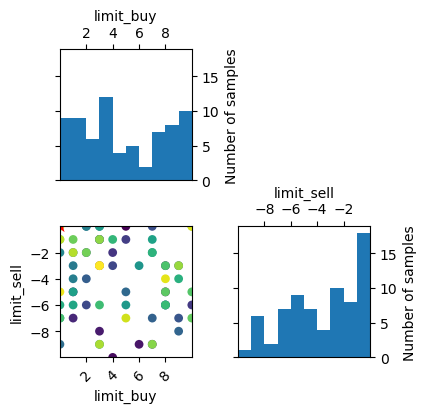

In [22]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

#### Density

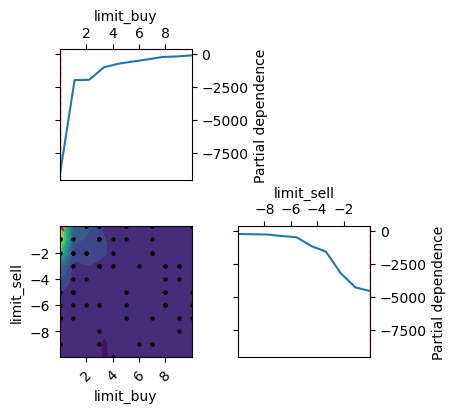

In [23]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="08D_Smart Optimization to Save Computing Time.ipynb">notebook</a>.